# Optik Koherens Tomografiden hastalık teşhisi (Sınıflandırma)

<img src=https://raw.githubusercontent.com/brktzlk/OCT_Hastalik_Teshisi/main/Resimler/oct.jpg width="750" align="left">

        21. yüzyılda, optik koherens tomografinin (OCT) gelişimi, maküler hastalıkları teşhis etme ve tedavilerin gerekliliğini ve etkinliğini değerlendirme becerisinde çığır açmıştır. Dünya çapında her yıl gerçekleştirilen yaklaşık 30 milyon OCT taramasıyla en sık uygulanan tıbbi görüntüleme prosedürlerinden biri haline geldi. OCT görüntüleme artık dünya çapında önlenebilir körlüğün önde gelen nedenlerinden yaşa bağlı makula dejenerasyonu (AMD) ve diyabetik maküla ödeminin tanı ve tedavisine rehberlik eden bir standart haline gelmiştir.

-------------------------------------------------------------------------------------------------------------------------------------

# Veri seti

   OCT verilerini [buradan](https://data.mendeley.com/datasets/rscbjbr9sj/2) indirebilirsiniz.

-------------------------------------------------------------------------------------------------------------------------------------

## Standart kütüphaneleri içe aktarma

In [69]:
# !pip install opencv-python
# !pip install tensorflow

In [70]:


import os #operation system
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt


seed=2020
np.random.seed(seed)
%matplotlib inline


## Dosyanın bulunduğu konum

In [71]:
path="C:/Users/yusuf/Desktop/GOALS/DEEP_LEARNING/AI_Health_issues/OCT2017/"
train=path+ "train/"
test=path + "test/"


test,path,train


('C:/Users/yusuf/Desktop/GOALS/DEEP_LEARNING/AI_Health_issues/OCT2017/test/',
 'C:/Users/yusuf/Desktop/GOALS/DEEP_LEARNING/AI_Health_issues/OCT2017/',
 'C:/Users/yusuf/Desktop/GOALS/DEEP_LEARNING/AI_Health_issues/OCT2017/train/')

## Veri büyütme  (Data augmentation) 

[ImageDataGenerator()](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) 

In [72]:


#verileri çoğaltma işlemi

from keras.preprocessing.image import ImageDataGenerator

#Yapacağımız data augmentation'da horizontal flip,zoom range olacaktır. vertical_flip yapmak hastalığın şeklini bozacağından bunu içine katmıyoruz
                                   
train_datagen=ImageDataGenerator(horizontal_flip=True,zoom_range=0.29)


test_datagen = ImageDataGenerator()


## Görüntüleri aktarma

[flow_from_directory()](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) 

In [73]:
#flow_from_directory: Belirten konumdaki(directory) dosyaları alır ve veri yığınları(batch) oluşturur. Belirtilen konumun altında en az bir dizin olmasını bekler.


train_gen=train_datagen.flow_from_directory(directory=train,
                                            target_size=(160,160),#150 ve 200 arasındaki bir değer hem modelimiz hem de bilgisayarımız için yeterli gelecektir.                            ) #150 ve 200 arasındaki bir değer hem modelimiz hem de bilgisayarımız için yeterli gelecektir.
                                            batch_size=8,#2'nin katları girilmesi önerilir ancak fazla girilmesi model için iyiken , bilgisayarı yorar.
                                            shuffle=True)


#Aynısını test içinde yapalım.
test_gen=test_datagen.flow_from_directory(directory=test,
                                            target_size=(160,160),#150 ve 200 arasındaki bir değer hem modelimiz hem de bilgisayarımız için yeterli gelecektir.                            ) #150 ve 200 arasındaki bir değer hem modelimiz hem de bilgisayarımız için yeterli gelecektir.
                                            batch_size=8,#2'nin katları girilmesi önerilir ancak fazla girilmesi model için iyiken , bilgisayarı yorar.
                                            shuffle=True)                                                                   
                            
                         
                            
                     

                    
                            
                            
                            
                            
                            

Found 53738 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [74]:
train_gen[0][0].shape #batch_size boyutunu gosterdık

train_gen[0][0][6].shape #batch'in içindeki herhangi bir resmi gösterdik.


(160, 160, 3)

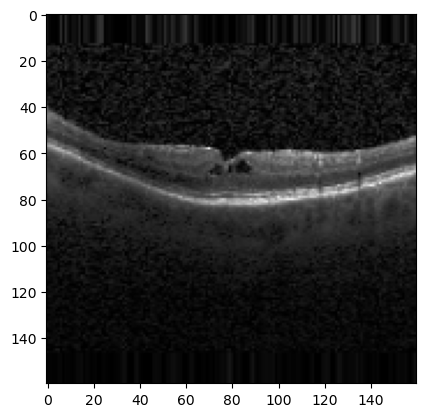

In [75]:
#Veri setinden örnekleri gösterme
plt.imshow(train_gen[0][0][7]/255)

### Callbacks 
1. Öğrenme katsayısı azaltma [ReduceLROnPlateau()](https://keras.io/api/callbacks/reduce_lr_on_plateau/) 
2. Kontrol noktası - Her epochta ağırlıkları kaydetme [ModelCheckpoint()](https://keras.io/api/callbacks/model_checkpoint/)


In [76]:
#şimdi modelimizi eğitirken learning_rate nasıl otomatik olaarak nasıl artırıp azaltacağız ona bakalım.
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

lr=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.25,min_lr=0.000001)
#monitor(izlenen yer), neyi baz alacağı
#patience gösterilen sabır
#verbose ve mode önemli değil

#factor,hep aynı sonucu veren learning rate ile çarpılma sonucu
#min_lr= gidilecek en küçük öğrenme oranını temsil eder.

cp=ModelCheckpoint(filepath="TransferLearningEfficent.h5",save_weights_only=True)#burada sadece modelin ağırlıklarını kaydediyoruz.


## Model Oluşturma - Transfer Learning ( EfficientNet B5 )

    Araştırma yapılırken(2018) transfer learning modeli olarak InceptionV3 kullanılmış ve %96.6 accuracy skoru elde edilmiş. Fakat günümüzde(2020) InceptionV3'den daha başarılı modeller mevcut. Bu nedenle kursta EfficientNet modelini kullanıyoruz. Bu model accuracy skoru %99.3'ye kadar çıkartabiliyor 

In [77]:
#Model oluşturma

from efficientnet.keras import EfficientNetB5

#Son yoğun katmanları isteyip istemediğimizi seçmememizi sağlar.
#İstediğimizde True , istemediğimizde False işaretleriz


#Şimdi kendi çıkış katmanlarımızı eklememiz gerekiyor.
from keras.models import Sequential
from keras import layers


model=Sequential () 
model.add(EfficientNetB5(weights="imagenet",include_top=False,input_shape=(160,160,3))) #biz transfer learning'in oluşturduğu feature map() yüksek olmayan  ) kullanıp daha başarılı sonuçlar elde etmek istiyoruz.
#ağırlıklar olarak imagenet kullanıp, input_shape ise resimlerin boyutlarını giriyorum

#Son katmanları çıkardık, şimdi son katmanları kendimizce ekleme zamanı:
NUM_OF_CLASS=4#sınıflandırma sayım 4 olduğu için 4 olarak belirledim.

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(NUM_OF_CLASS,activation="softmax"))




#Modeli derleme işlemi
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)




#### Eğitim

In [78]:
history=model.fit(train_gen,
                  validation_data=test_gen,
                  batch_size=8,
                  epochs=1,  #temsili olarak 2 epoch yapılmıstır.
                  callbacks=[lr,cp])

6718/6718 [==============================] - 31043s 5s/step - loss: 0.3724 - accuracy: 0.8816 - val_loss: 0.0293 - val_accuracy: 0.9950 - lr: 0.0010


# Accuracy-Loss grafiği

#### Accuracy

#### Loss

#### Verileri aktarma 

In [79]:
#simdi confusion matrix olusturabilmem icin dosyalardan goruntuleri ve label'larını almam gerekiyor.
test

dosya=os.listdir(test)
dosya

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [80]:
import glob
import cv2



test_data = [] #yaptığımız for'daki goruntuleri buraya
label_test= [] #if elif elde ettiğimiz label'ları ise buraya ekleyeceğiz.







dosya=os.listdir(test)
dosya #bunun icinde bulunan klasorlerin resimlerine ulasmam icin for kullanicam.
for sinif in dosya:
  print(sinif)#CNV,DME,NORMAL gosterecektir.
  yol=test + '\\'+ sinif #tum test`in dosya yolunu gosterir.
  for img in glob.glob(yol + '\\*'): #tum dosyalarin icindeki resimlere ulasmis olduk 
    # print(img)# şuan dosyalardaki tum fotoğraflara erişimiz var.                          
    img=cv2.imread(img)
    img=cv2.resize(img,(160,160))
    #yapacağımız son işlem ise, göruntunun tipini değiştirmek olacaktır. Çunku
    img.astype('float32')
    #biz goruntulerimizi eğitime sokarken, 160x160lık goruntulerle ondalık tensorlerle işlemler yapmıştık.


    #Sınıflandırma için
    if sinif=='CNV':
      label=0
    elif sinif=='DME':
      label=1
    elif sinif=='DRUSEN':
      label=2
    elif sinif=='NORMAL':
      label=3
    #ekleme işlemleri
    print(label)

    test_data.append(img)
    label_test.append(label)

    #yapılan işlemleri check etme
    # print(len(test_data)) #her döngude list içerisindeki resim sayısını dondurecektır.

CNV
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
DME
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


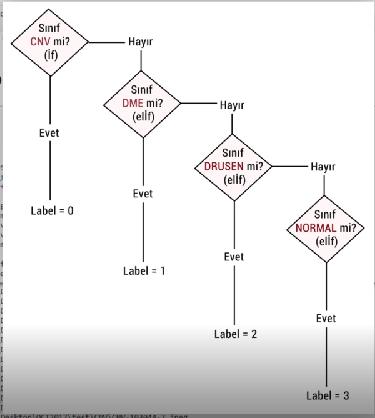

Son bir işlem olarak, list şeklindeki aldığımız resimleri array formatına dönusturmemiz gerekiyor.

In [81]:
#bunu yapmamızın sebebi list formatında,shape alamamız ve hata matrisine bu şekilde veremeyecek olmamızdır.
x_test=np.asarray(test_data)

print(x_test.shape) #artık boyutunu öğrenebiliriz.

#aynı işlemi labellar içinde yapıyoruz.

y_test=np.asarray(test_label)

print(y_test.shape)

(1000, 160, 160, 3)
(1000,)


##HATA MATRİSİ (Confusiom Matrix) 

In [82]:
#grafikleri oluştururken,genelde uc tane veriye ihtiyacımız oluyor.
#bunlar sırasıyla :
#y_true = Doktorlar tarafından belirlenmiş sonuçlar (ground truth)
#y_pred= bir sınıflandırıcı tarafından,yapılan tahmini sonuçlar, elde etmek için model.predict_classes() ile edilir.
#y_probas =bir sınıflandırıcı tarafından,yapılan sonuçlar, elde etmek için model.predict() ile edilir Ancak veriler OLASILIKSAL ŞEKİLDEDİR.

y_true=y_test

y_probas=model.predict(x_test)

32/32 [==============================] - 135s 4s/step


In [83]:
y_pred=np.argmax(y_probas>0.5,axis=-1) #axis -1
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(y_true,y_pred)
#ÖNEMLİ:

"""
Eğer bilimsel bir çalışma yapıyorsanız,Grafiklerin ne anlama geldiğini *net* bir şekilde açıklamalısınız.

"""

'\nEğer bilimsel bir çalışma yapıyorsanız,Grafiklerin ne anlama geldiğini *net* bir şekilde açıklamalısınız.\n\n'

# Hata matrisi - Confusion matrix

Text(45.722222222222214, 0.5, 'Gerçek')

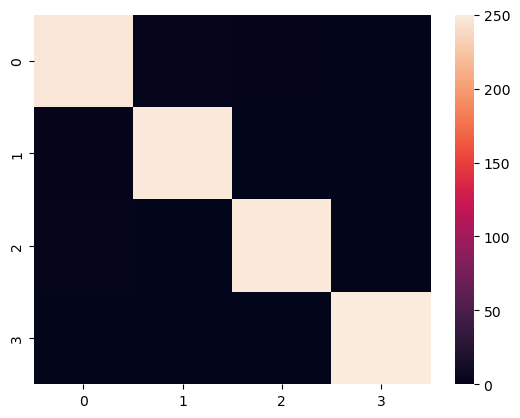

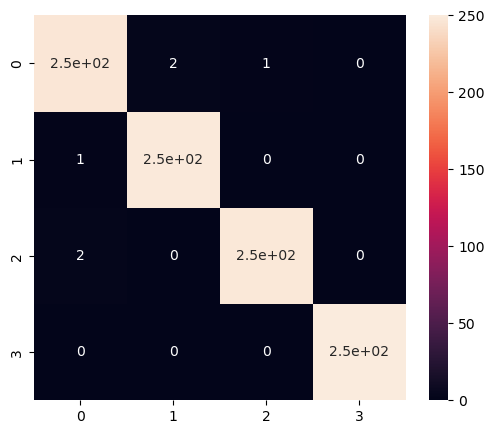

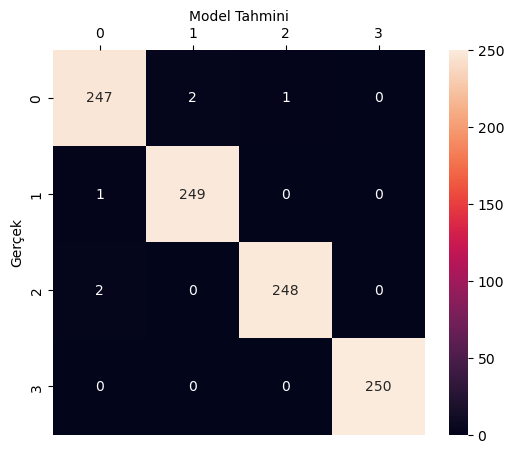

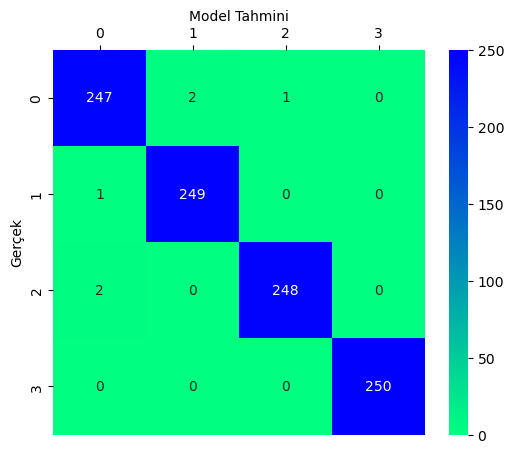

In [85]:
#adım adım confusion matrix'in nasıl daha iyi bir hale getirildiğine bakalım

#1.hali
sns.heatmap(cm) #ustundeki sayıların bile yazmadığı bir kırmızı harita.

#2.hali
plt.figure(figsize=(6,5)) #kare şeklinde gözukmesini sağlar.
sns.heatmap(cm,annot=True) #annot =bi açıklama veya (gösterge) koymak için kullanılır

#3.hali
plt.figure(figsize=(6,5)) #kare şeklinde gözukmesini sağlar.
hm=sns.heatmap(cm,annot=True,fmt='n') #annot =bi açıklama veya (gösterge) koymak için kullanılır.
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel("Model Tahmini") #X eksenimize bir başlık atıyoruz.bunu bu şekilde bırakırsanız altta gözucektir.
hm.xaxis.set_label_position('top')#ustte gosterecektir.
hm.set_ylabel("Gerçek")


#4.hali (Renkleriyle degistirilmiş hali)

plt.figure(figsize=(6,5)) #kare şeklinde gözukmesini sağlar.
hm=sns.heatmap(cm,annot=True,fmt='n',cmap="winter_r") #annot =bi açıklama veya (gösterge) koymak için kullanılır. #cmap tablonun rengini belirler.
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel("Model Tahmini") #X eksenimize bir başlık atıyoruz.bunu bu şekilde bırakırsanız altta gözucektir.
hm.xaxis.set_label_position('top')#ustte gosterecektir.
hm.set_ylabel("Gerçek")


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

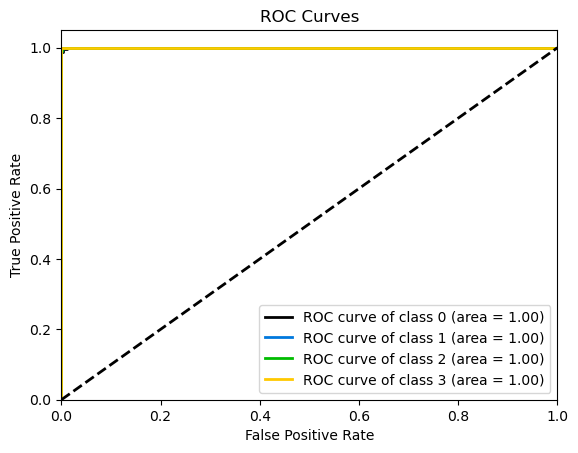

In [89]:
#ROC eğrisi genellikle Binary Sınıflandırma'da kullanılır sci-kit Learn'de. Ancak biz 4 farklı sınıfına sahip olduğumuz için,
#bunu farklı bir kutuphaneden yapacağız.
# !pip install scikit-plot
import scikitplot as spklt

spklt.metrics.plot_roc(y_true,y_probas,#burada y_probas değerlerini istiyor burada örneğin.
                       plot_macro=False,
                       plot_micro=False) #macro ve micro göstergelerinin kaldırılması 
                       
#ROC EĞRİSİ Duzenleştirme. Turkçe ifadeler ekleme.
#scikitplot kutuphanesinde matplotlib kutuphanesinin altyapısını kullanmaktadır.


                       


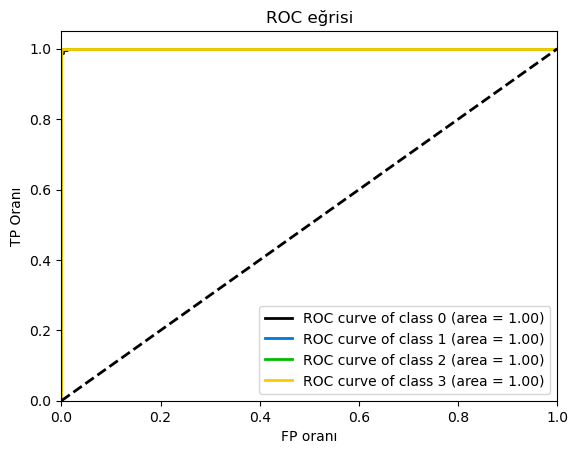

In [90]:
#aradaki farkı görmek için iki tane çizelim.
spklt.metrics.plot_roc(y_true,y_probas,#burada y_probas değerlerini istiyor burada örneğin.
                       plot_macro=False,
                       plot_micro=False) #macro ve micro göstergelerinin kaldırılması 
plt.title("ROC eğrisi")

plt.xlabel("FP oranı")
plt.ylabel('TP Oranı')
plt.show()

In [ ]:
#It's done.